# Preprocess data for LSTM and GPT models

We have to create special prompts in order to train our text generation models to generate the next words in the sentence or article. Below is the code used to subset our data of 16,000+ books to only 5,000 to speed up training.

In [14]:
import pandas as pd
filename = 'data/booksummaries.txt'
df = pd.read_csv(filename, sep="\t", 
                 names=['Wikipedia ID', 'Freebase ID', 'Title', 'Author', 'Publication Date', 'Genres', 'Summary'])

In [8]:
import json

# drop data with NaN values
df = df.drop_duplicates(subset=['Wikipedia ID'])
df = df.dropna(subset=['Genres', 'Summary'])
df['Genres'] = df['Genres'].map(lambda genre : list(json.loads(str(genre)).values()))

KeyError: Index(['Wikipedia ID'], dtype='object')

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_counts(df):
    genre_counts = dict()
    for genre in df['Genres'].map(str):
        if genre in genre_counts.keys():
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

    return pd.DataFrame({"Genre": list(genre_counts.keys()),
                    "Counts": list(genre_counts.values())})

def plot_counts(df, pathname):    
    g_df = get_counts(df)
    genres = g_df.nlargest(columns=["Counts"], n=50)
    plt.figure(figsize=(15,10)) 
    ax = sns.barplot(data=genres, x= "Counts", y = "Genre") 
    ax.set(xlabel = 'Counts', ylabel = 'Top 50 Genres')
    plt.title('Counts per Genre for the Top 50 Genres')
    plt.savefig(f'data/{pathname}.png',bbox_inches="tight")
    plt.show()

In [6]:
def get_genres_str(genre_list):
  genre_str = ''
  for g in genre_list:
    genre_str += (g + ', ')
  return genre_str[:-2]

In [17]:
# go thru data and clean up
new_data = []
df = df.reset_index()  # make sure indexes pair with number of rows

# create prefix which is the input prompt for our models
prefix = 'Generate a book summary with genres '

for index, row in df.iterrows():
    stringified_row = prefix + get_genres_str(row['Genres']) + ':\n'+ row['Summary']
    new_data.append(stringified_row)

print(new_data[0])

Generate a book summary with genres Roman à clef, Satire, Children's literature, Speculative fiction, Fiction:
 Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball annou

In [5]:
# create new dataframe
with_prompt_df = pd.DataFrame(new_data, columns=['Text'])
with_prompt_df.sample(5000).head()

NameError: name 'new_data' is not defined

In [19]:
# save only 5000 to a new file
compression_opts = dict(method='zip', archive_name='5000_booksummaries.csv')
with_prompt_df.sample(n=5000).to_csv('data/5000_booksummaries.zip', compression=compression_opts,index=False)

In [1]:
# use for models: do not run here! copy and paste into respective model files
import pandas as pd
filename = 'data/5000_booksummaries.zip'
df = pd.read_csv(filename)
df.head(5)

,Text
0,Generate a book summary with genres Science Fi...
1,Generate a book summary with genres Fantasy:\n...
2,Generate a book summary with genres Crime Fict...
3,"Generate a book summary with genres Fiction, N..."
4,"Generate a book summary with genres War novel,..."


In [37]:
df['Genres'] = df['Text'].apply(lambda x: x.split(':\n')[0])
df['Genres'] = df['Genres'].apply(lambda x: x.split(' ')[6: ])
df['Genres'] = df['Genres'].apply(lambda x: ' '.join(x).split(', '))

df.head()

,Text,Genres
0,Generate a book summary with genres Science Fi...,"[Science Fiction, Speculative fiction]"
1,Generate a book summary with genres Fantasy:\n...,[Fantasy]
2,Generate a book summary with genres Crime Fict...,"[Crime Fiction, Mystery, Suspense]"
3,"Generate a book summary with genres Fiction, N...","[Fiction, Novel]"
4,"Generate a book summary with genres War novel,...","[War novel, Fiction]"


FileNotFoundError: [Errno 2] No such file or directory: 'data/figures/mostcommon5000genres.png'

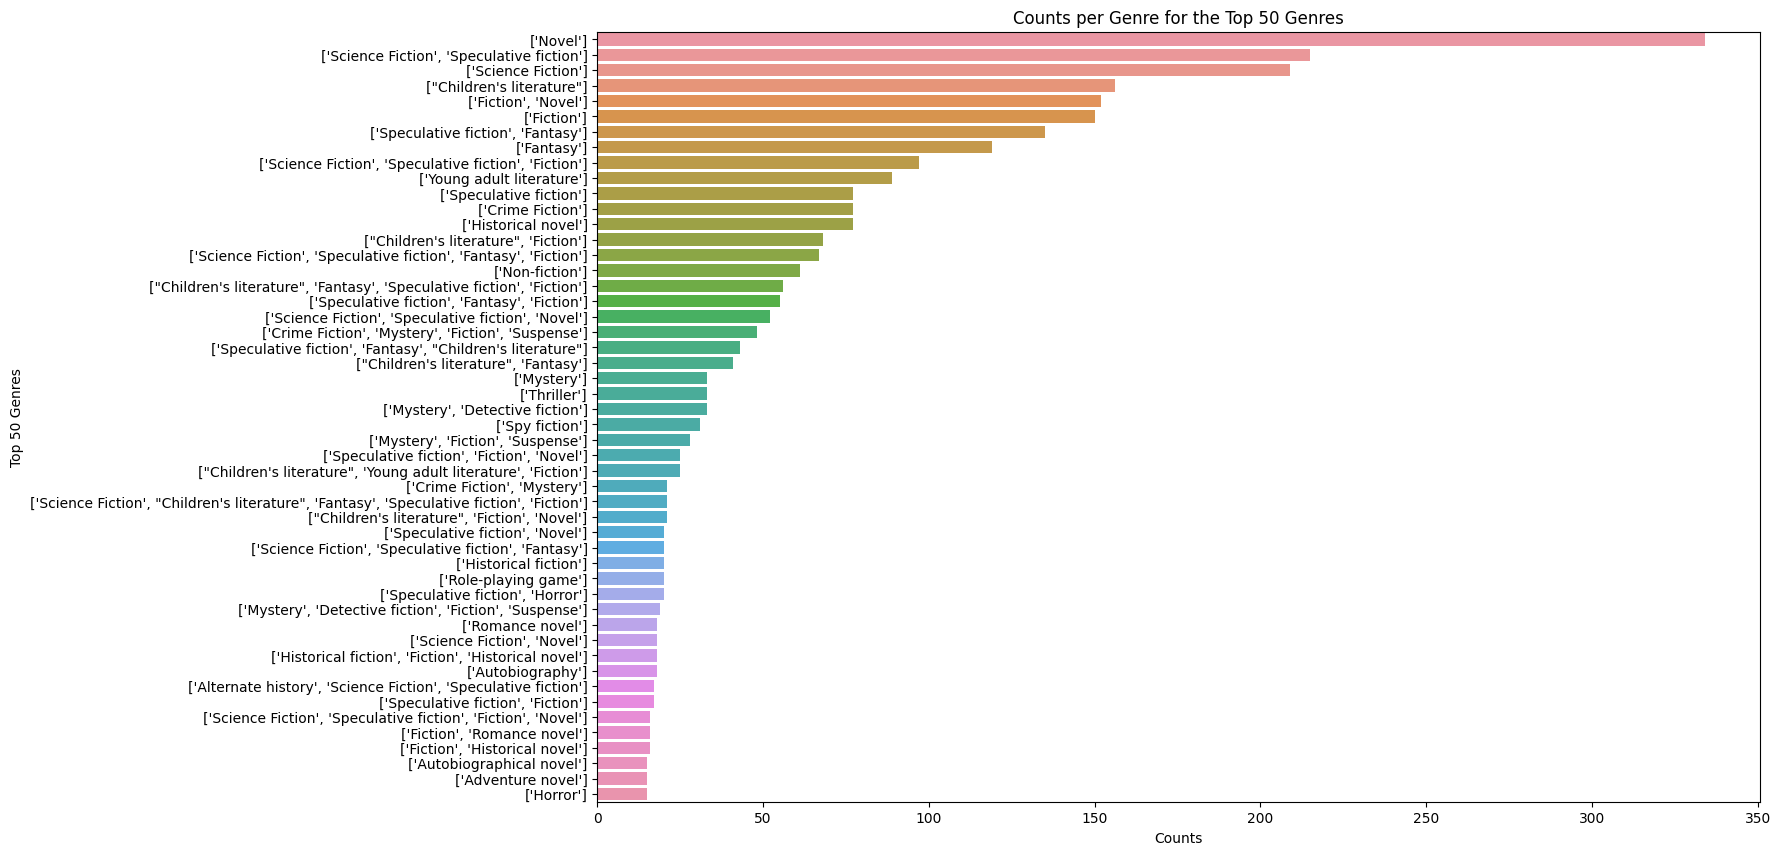

In [39]:
plot_counts(df, '../CS224N-Book-Summaries/figures/mostcommon5000genres')